<a href="https://colab.research.google.com/github/aSafarpoor/Seminar/blob/main/image_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source link: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [1]:
# !pip install tensorflow==2.6.0
# !pip install keras~=2.6.0

In [2]:
import json
from tqdm import tqdm
import random
from collections import Counter
import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import requests
from io import BytesIO

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive
%cd MyDrive
%cd Seminar
!ls

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Seminar
AMAZON_FASHION.json	meta_AMAZON_FASHION.json     model.bin
AMAZON_FASHION.json.gz	meta_AMAZON_FASHION.json.gz  user_item_matrix.p
embedded_text.p		meta_data.p		     user_tweets.p


In [5]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz

In [6]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_AMAZON_FASHION.json.gz

In [7]:
# !ls

In [8]:
# !gunzip -k AMAZON_FASHION.json.gz

In [9]:
# !gunzip -k meta_AMAZON_FASHION.json.gz

In [10]:
!ls

AMAZON_FASHION.json	meta_AMAZON_FASHION.json     model.bin
AMAZON_FASHION.json.gz	meta_AMAZON_FASHION.json.gz  user_item_matrix.p
embedded_text.p		meta_data.p		     user_tweets.p


# collect data

In [11]:
with open('embedded_text.p', 'rb') as fp:
    df = pickle.load(fp)

In [12]:
df.columns

Index(['title', 'brand', 'feature', 'rank', 'date', 'asin', 'imageURL',
       'imageURLHighRes', 'description', 'price', 'also_view', 'also_buy',
       'fit', 'details', 'similar_item', 'tech1', 'embedded_description'],
      dtype='object')

In [13]:
li = list(df.imageURL)
hi = list(df.imageURLHighRes)

In [14]:
li[0],hi[0]

(['https://images-na.ssl-images-amazon.com/images/I/4196%2BTu5T%2BL._SR38,50_.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/31N2zBaedSL._SR38,50_.jpg'],
 ['https://images-na.ssl-images-amazon.com/images/I/4196%2BTu5T%2BL.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/31N2zBaedSL.jpg'])

In [98]:
def im_reader(link , draw=False , pil=False):
    response = requests.get(link)
    img = Image.open(BytesIO(response.content))
    if pil:
        return img
    im2arr = np.array(img)
    if draw:
        imgplot = plt.imshow(im2arr)
        plt.show()
    return im2arr

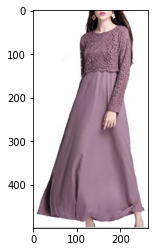

In [99]:
img = im_reader(hi[0][0],True)


# embedding phase

In [100]:
# import cv2
# dim = (100,100,3)
# resized_image = cv2.resize(img, (224, 224)) 
# resized_image.reshape(224,224,3)
# img.shape ,resized_image.shape

In [101]:
# imgplot = plt.imshow(img)
# plt.show()

In [93]:
from torchvision import models
import torch
# dir(models)

In [94]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [95]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [96]:
from torchvision import transforms

transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
    mean=[0.485, 0.456, 0.406],                #[6]
    std=[0.229, 0.224, 0.225]                  #[7]
)])


In [111]:
def batch_t_creator(url):
    img = im_reader(url,True,True)
    img_t = transform(img)
    # print(img_t)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

In [104]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [105]:
out = alexnet(batch_t)
print(out.shape)

torch.Size([1, 1000])


In [110]:
print(out[0].shape)

torch.Size([1000])


In [ ]:
out_list = []
c = 0
for i in range(10):
    a = hi[i]
    print()
    for j in a:
        print(c)
        c+=1
        batch_t = batch_t_creator(url=j)
        out = alexnet(batch_t)
        out_list.append(out)

In [115]:
len(out_list) ,  len(out_list[0][0])

(28, 1000)

In [139]:
def cosine(u, v):
    return (np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))

In [ ]:
for i in range(28):
    # print('\n',i)
    for j in range(28):
        sim = cosine(out_list[i][0].detach().numpy(),out_list[j][0].detach().numpy())
        # print(j,':',int(100*sim) ,end=' - ')
        if sim>0.8 and i != j:
            print(i,j)

In [ ]:
out_list = []
# c = 0
for i in tqdm(range(1000)):
    a = hi[i]
    # print()
    for j in a:
        # print(c)
        # c+=1
        batch_t = batch_t_creator(url=j)
        out = alexnet(batch_t)
        out_list.append(out)

  6%|▋         | 65/1000 [00:42<16:03,  1.03s/it]